In [1]:
%matplotlib inline
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xml.etree.ElementTree as ET
from collections import Counter
from itertools import product, zip_longest

Get index pairs from stats file.

In [2]:
tree = ET.parse('../data/output/Stats/DemultiplexingStats.xml')
root = tree.getroot()

index_pairs = []

for index_pair in root.iter('Barcode'):
  name = index_pair.get('name')
  if name != "all":
    index_pairs.append((name, int(index_pair[0].find('BarcodeCount').text)))

index_pairs = sorted(index_pairs, key=lambda x: x[1], reverse=True) # All index pairs from sample sheet (not all were present in sequencing run)
index_pairs_present = [index_pair for index_pair in index_pairs if index_pair[1]] # Only indexes observed in sequencing run

print(len(index_pairs)) # should be 97 (96 + unknown)
print(len(index_pairs_present)) # should be 45 (44 + unknown)

97
45


Load results from GSC MiSeq QC run and compare to our demultiplexing run. These were independently demultiplexed by GSC, so this is a sanity check to make sure bcl2fastq worked as expected.

In [3]:
GSC_results = pd.read_csv('../data/GSC_demultiplex_stats.csv')
# GSC_results

Check that our counts match the GSC counts for each index pair.

In [4]:
comparison = ["{:<20} {:<10} {:<10} {:<10}".format(*['Barcode', 'Our Count', 'GSC Count', 'Equal'])]
for index_pair, count in index_pairs_present:
  if index_pair in list(GSC_results['Barcode sequence']):
    GSC_count = int((GSC_results.loc[GSC_results['Barcode sequence'] == index_pair].iloc[0]['PF Clusters']).replace(',', ''))
    comparison.append("{:<20} {:<10} {:<10} {:<10}".format(*[index_pair, count, GSC_count, count == GSC_count]))

print('\n'.join(comparison))

Barcode              Our Count  GSC Count  Equal     
CTTCGGTC+CATCGTTA    53944      53944      1         
TGCGAGGA+TACGGTTA    50517      50517      1         
TACGATTC+CGGAAGAG    47636      47636      1         
AGAATCAG+TACGACAG    45817      45817      1         
AGCATAGT+CAGTCGAG    41549      41549      1         
TACCTGGT+TGAGGTCT    40380      40380      1         
unknown              39915      129523     0         
TCTTCCTG+TTCCAACG    36409      36409      1         
CTAGAACC+TGGTCTAA    34626      34626      1         
CACAATCG+TCAACTCA    26354      26354      1         
ACGCCACA+CCGAACCA    19363      19363      1         
TTCCAATC+TTACGCTA    19327      19327      1         
ACGGAGGT+CGAGAGTT    18587      18587      1         
TAACATGC+ACACTCAT    18524      18524      1         
CGCTTCCT+ACCACTGA    17421      17421      1         
CTGAGAGG+TAGCTACG    15812      15812      1         
ACTATTGC+TCCTGTGT    15063      15063      1         
CCGTACAT+CAACTGAA    14868  

Only 'unknown' has different counts. This is because we gave them incorrect indexes for 9 of the libraries, so reads from these libraries were part of the 'unknown' counts when GSC first tried demultiplexing.

Get all barcodes that were not demultiplexed. Only need to read the R1 undetermined file because both indexes are in the identifier line.

In [5]:
def parse_fastq_gz(fastq):
    with gzip.open(fastq, 'rb') as f:
        fastq_iter = (l.decode('utf-8').rstrip() for l in f)
        for read in zip_longest(*[fastq_iter] * 4):
            yield read

In [6]:
discarded = []
for read in parse_fastq_gz('../data/output/Undetermined_S0_L001_R1_001.fastq.gz'):
  discarded.append(read[0][-17:]) # Index sequences are last 17 characters in line

print(len(discarded))
# print(discarded[0])

39915


39915 reads didn't demultiplex. This matches the "unknown" count. A good portion of these discarded reads are PhiX pike-in, which had the index pair ATCTCGTA+TCTTTCCC.

In [7]:
discarded_counts = Counter(discarded)
print(discarded_counts['ATCTCGTA+TCTTTCCC'])
discarded_unique = set(discarded)

11313


11313 reads were from the PhiX with no mismatches in the barcode.

Remove PhiX index pair and any other index pairs from discarded_counts such that both indexes are within Hamming distance of 1 from the true PhiX indexes (this simulates what bcl2fastq would do). Add the PhiX index and read counts to index_pairs_present. Also remove "unknown" from index_pairs_present.

In [8]:
def hamming(a, b):
  return(sum(i != j for i, j in zip(a, b)))

correct_index1 = 'ATCTCGTA'
correct_index2 = 'TCTTTCCC'
phiX_reads = 0
phiX_discarded = []
for discarded_pair in discarded_unique:
  index1 = discarded_pair[:8]
  index2 = discarded_pair[9:]
  if hamming(correct_index1, index1) <= 1 and hamming(correct_index2, index2) <= 1:
    phiX_reads += discarded_counts[discarded_pair]
    phiX_discarded.append(discarded_pair)


index_pairs_present = [i for i in index_pairs_present if i[0] != 'unknown']
index_pairs_present.append(('ATCTCGTA+TCTTTCCC', phiX_reads))

discarded_unique = [x for x in discarded_unique if x not in phiX_discarded]

for pair in phiX_discarded:
  discarded_counts.pop(pair)

Check how many unique index pairs are present in the discarded reads.

In [9]:
print(len(discarded_counts))
# print(len(discarded_unique))
print(phiX_reads)

21194
11650


Check how many reads didn't demultiplex after removing PhiX reads.

In [10]:
print(discarded_counts.total())
print(discarded_counts.total() + phiX_reads)

28265
39915


28265 reads didn't demultiplex. Look at Distribution of read counts for index pairs that didn't demultiplex.

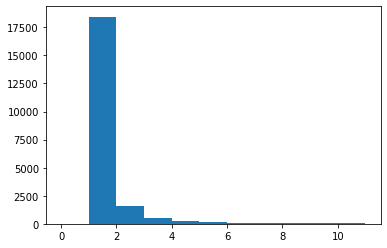

In [11]:
plt.hist(discarded_counts.values(), bins=range(12))
plt.show()

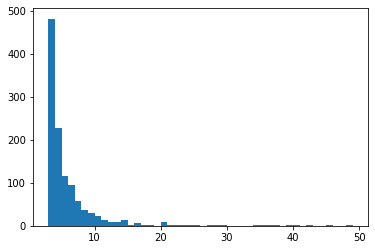

In [12]:
plt.hist(discarded_counts.values(), bins=range(3, 50))
plt.show()

Now check how many discarded reads had index pairs that were the result of a deletion in one or both indexes. For MiSeq, a deletion in either index will result in an 'A' at the 8th position of the index. For each correct index pair, generate all index pair combinations that could result from a single deletion in one or both indexes.

In [13]:
def all_deletions(seq):
  deletions = [seq]
  for i in range(len(seq)):
    seq_bases = [base for base in seq]
    seq_bases.pop(i)
    seq_bases.append('A')
    deletions.append(''.join(seq_bases))
  return deletions

# print(all_deletions('ACGT'))

def all_deletion_combinations(idx1, idx2):
  return [i + '+' + j for i, j in product(all_deletions(idx1), all_deletions(idx2))]

# print(all_deletion_combinations('ACTG', 'GTCA'))

Get deletion index pairs present in the discarded reads and the counts for each pair.

In [14]:
observed_deletions = {}

for index_pair, frequency in index_pairs_present:
  pair_observed_deletions = []
  deletions = all_deletion_combinations(index_pair[:8], index_pair[9:])
  for deletion in deletions:
    if deletion in discarded_unique:
      pair_observed_deletions.append((deletion, discarded_counts[deletion]))
  # Converting list to dict here accounts for cases where the same index pair is present
  # multiple times in the list of all possible combinations (identical tuples are collapsed).
  observed_deletions[index_pair] = Counter(dict(pair_observed_deletions))

# observed_deletions['CTTCGGTC+CATCGTTA']


Check how many discarded reads were the result of a deletion in one or both indexes.

In [15]:
print(sum(pairs.total() for pairs in observed_deletions.values()))

1435


For each index pair, find all discarded index pairs such that each index in the discarded pair is within Levenshtein distance of two from the correct index.

In [16]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [17]:
similar_index_pairs = {}

for index_pair, frequency in index_pairs_present:
  similar_to_pair = []
  correct_index1 = index_pair[:8]
  correct_index2 = index_pair[9:]
  for discarded_pair in discarded_unique:
    index1 = discarded_pair[:8]
    index2 = discarded_pair[9:]
    if levenshtein(correct_index1, index1) <= 2 and levenshtein(correct_index2, index2) <= 2:
      similar_to_pair.append((discarded_pair, discarded_counts[discarded_pair]))
  similar_index_pairs[index_pair] = Counter(dict(similar_to_pair))

# similar_index_pairs['CTTCGGTC+CATCGTTA']

In [18]:
print(sum(pairs.total() for pairs in similar_index_pairs.values()))

13325


Look at number of discarded reads with indexes within Levenshtein distance of 2 and number of discarded reads with a single deletion in one or both indexes for each sample.

In [19]:
index_stats = pd.DataFrame(index_pairs_present, columns=['Index', 'Demultiplexed Reads'])
index_stats = index_stats.drop(6) # get rid of unknown

In [20]:
index_stats['Similar Index Count'] = [len(similar_index_pairs[index]) for index in index_stats['Index']]
index_stats['Similar Index Reads'] = [similar_index_pairs[index].total() for index in index_stats['Index']]
index_stats['Similar Index Percent'] = index_stats['Similar Index Reads']/(index_stats['Demultiplexed Reads'] + index_stats['Similar Index Reads']) * 100

index_stats['Deletion Index Count'] = [len(observed_deletions[index]) for index in index_stats['Index']]
index_stats['Deletion Index Reads'] = [observed_deletions[index].total() for index in index_stats['Index']]
index_stats['Deletion Index Percent'] = index_stats['Deletion Index Reads']/(index_stats['Demultiplexed Reads'] + index_stats['Deletion Index Reads']) * 100
index_stats

,Index,Demultiplexed Reads,Similar Index Count,Similar Index Reads,Similar Index Percent,Deletion Index Count,Deletion Index Reads,Deletion Index Percent
0,CTTCGGTC+CATCGTTA,53944,246,557,1.022000,10,144,0.266233
1,TGCGAGGA+TACGGTTA,50517,203,366,0.719297,9,66,0.130479
2,TACGATTC+CGGAAGAG,47636,236,463,0.962598,11,123,0.257543
3,AGAATCAG+TACGACAG,45817,219,422,0.912649,13,83,0.180828
4,AGCATAGT+CAGTCGAG,41549,428,728,1.721976,14,109,0.261654
5,TACCTGGT+TGAGGTCT,40380,361,702,1.708778,11,90,0.222387
7,CTAGAACC+TGGTCTAA,34626,322,522,1.485149,9,61,0.175858
8,CACAATCG+TCAACTCA,26354,386,545,2.026098,11,39,0.147766
9,TACGTGCA+CGTCATTG,20511,351,492,2.342522,12,43,0.209205
10,TTAGTGGT+AAGGTCTG,19647,357,539,2.670167,6,19,0.096613


The PhiX barcode has a much lower frequency of deletions compared to the other barcodes: ~0.02% vs ~0.2% (PhiX sample is index 44: ATCTCGTA+TCTTTCCC)

In [21]:
mean_index_deletion = index_stats[index_stats['Index'] != 'ATCTCGTA+TCTTTCCC']['Deletion Index Percent'].mean()
phiX_index_deletion = index_stats[index_stats['Index'] == 'ATCTCGTA+TCTTTCCC']['Deletion Index Percent'].item()

print("Mean index deletion percent (our barcodes): ", mean_index_deletion)
print("phiX index deletion percent: ", phiX_index_deletion)

Mean index deletion percent (our barcodes):  0.16287143493596137
phiX index deletion percent:  0.017164435290078956


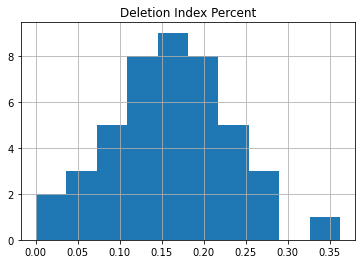

In [22]:
index_stats.hist('Deletion Index Percent')
plt.show()

In [23]:
sum(index_stats['Similar Index Reads'])

12713

12713 of the 28265 discarded reads had an index pair within our Levenshtein distance threshold of the correct index sequence. This is probably due to sequencing errors; the percent of similar discarded sequences for PhiX is similar to the percent for our samples.